<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/rag-with-python-cookbook/02_chunking_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

To ensure our RAG system finds the relevant information effectively, we need to create text chunks that clearly capture individual pieces of information. A strong data processing pipeline helps by cleaning up the raw text and splitting it at the right points to create meaningful chunks.

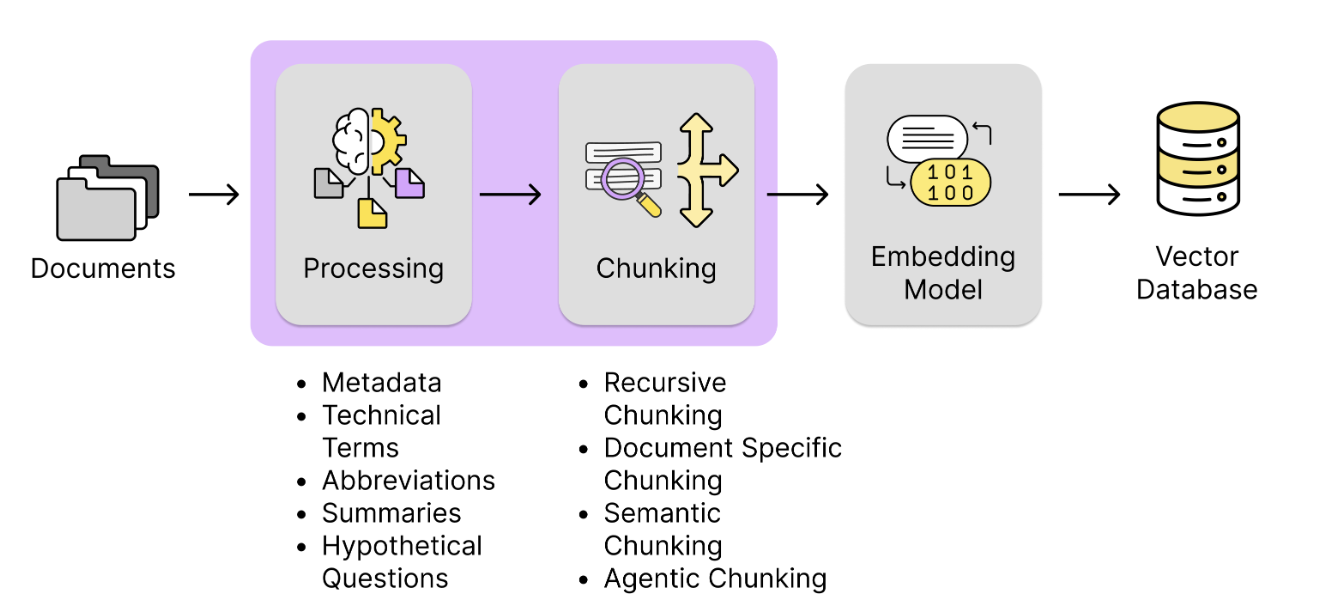

In [ ]:
!pip install PyPDF2==3.0.1
!pip install pandas==2.2.3
!pip install pydantic==2.11.5
#!pip install openai==1.83.0
!pip install matplotlib==3.10.3
!pip install scikit-learn==1.6.1
!pip install python-docx==1.1.2
!pip install nltk==3.9.1
!pip install langchain==0.3.25
#!pip install langchain_openai==0.3.21
!pip install langchain-experimental==0.3.4

In [ ]:
!pip install langchain-google-genai langchain_core

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from google.colab import userdata
import os

In [3]:
# --- Configuration ---
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [4]:
# Initialize the ChatGoogleGenerativeAI model
# Use a model that supports audio input, like "gemini-1.5-flash" or "gemini-1.5-pro"
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0, api_key=userdata.get("GOOGLE_API_KEY") )

## 2.1 Adding Metadata to Enable Metadata Filtering

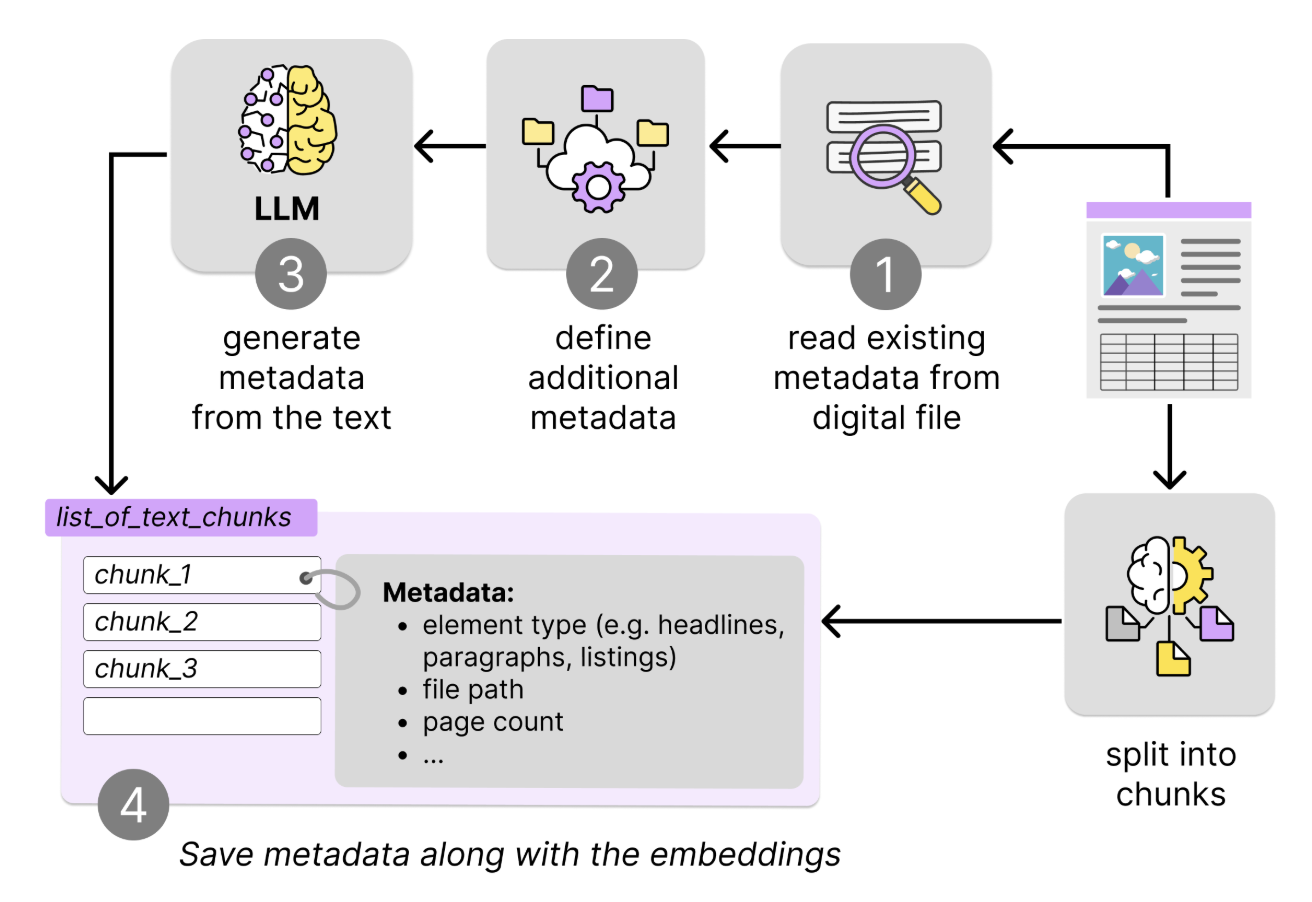

In [ ]:
!wget https://github.com/polzerdo55862/RAG-with-Python-Cookbook/raw/main/datasets/pdf_files/attention_is_all_you_need_paper.pdf

**Step 1**: Extract the metadata stored in the document

In [ ]:
import PyPDF2
import os

file_path = "attention_is_all_you_need_paper.pdf"

with open(file_path, "rb") as file:
    reader = PyPDF2.PdfReader(file)
    metadata = reader.metadata

    text = ""
    for page in reader.pages:
        text += page.extract_text()

In [ ]:
# text

**Step 2**: Add extra metadata like extraction time, file size, and more

In [ ]:
metadata = dict(metadata)
metadata["page_count"] = len(reader.pages)
metadata["file_size"] = os.path.getsize(file_path)
metadata["file_name"] = os.path.basename(file_path)
metadata["file_path"] = file_path
metadata["text_length"] = len(text)

In [ ]:
metadata

{'/Author': '',
 '/CreationDate': 'D:20240410211143Z',
 '/Creator': 'LaTeX with hyperref',
 '/Keywords': '',
 '/ModDate': 'D:20240410211143Z',
 '/PTEX.Fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5',
 '/Producer': 'pdfTeX-1.40.25',
 '/Subject': '',
 '/Title': '',
 '/Trapped': '/False',
 'page_count': 15,
 'file_size': 2215244,
 'file_name': 'attention_is_all_you_need_paper.pdf',
 'file_path': 'attention_is_all_you_need_paper.pdf',
 'text_length': 39472}

**Step 3**: Generate new metadata by analyzing the document text

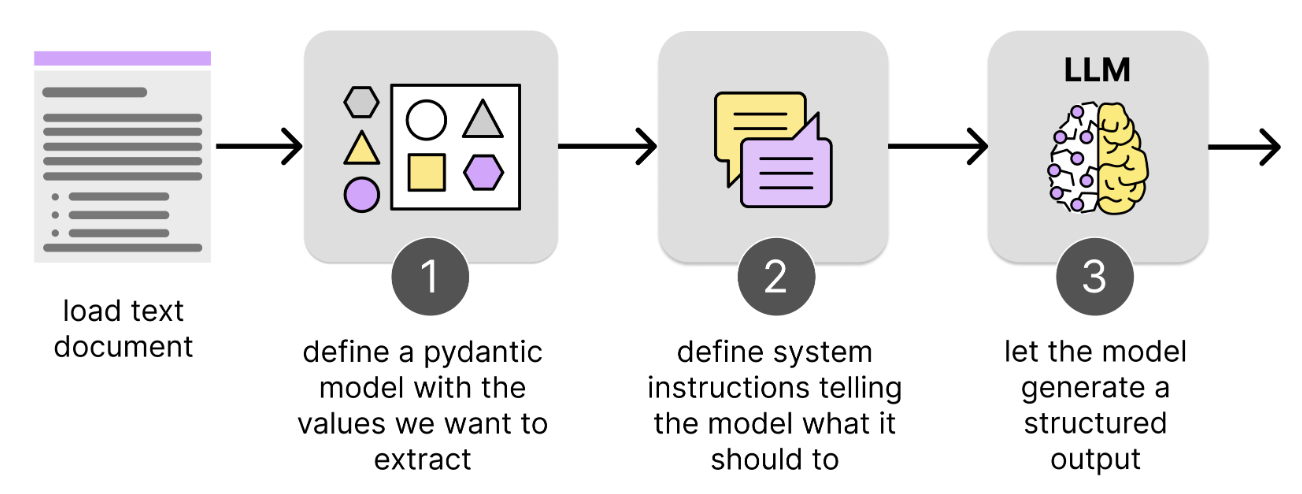

**Reference**:

https://python.langchain.com/docs/tutorials/extraction/

In [ ]:
from pydantic import BaseModel

class AuthorContact(BaseModel):
    name: str
    company: str
    email: list[str]

class Contacts(BaseModel):
    entries: list[AuthorContact]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [ ]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Extract the contact information of all authors."
        ),
        # Please see the how-to about improving performance with
        # reference examples.
        # MessagesPlaceholder('examples'),
        ("human", "{text}"),
    ]
)

In [ ]:
structured_llm = llm.with_structured_output(schema=Contacts)

In [ ]:
prompt = prompt_template.invoke({"text": text})

author_contacts = structured_llm.invoke(prompt)

In [ ]:
author_contacts

Contacts(entries=[AuthorContact(name='Ashish Vaswani', company='Google Brain', email=['avaswani@google.com']), AuthorContact(name='Noam Shazeer', company='Google Brain', email=['noam@google.com']), AuthorContact(name='Niki Parmar', company='Google Research', email=['nikip@google.com']), AuthorContact(name='Jakob Uszkoreit', company='Google Research', email=['usz@google.com']), AuthorContact(name='Llion Jones', company='Google Research', email=['llion@google.com']), AuthorContact(name='Aidan N. Gomez', company='University of Toronto', email=['aidan@cs.toronto.edu']), AuthorContact(name='Łukasz Kaiser', company='Google Brain', email=['lukaszkaiser@google.com']), AuthorContact(name='Illia Polosukhin', company='Google Research', email=['illia.polosukhin@gmail.com'])])

In [ ]:
metadata["author_contacts"] = author_contacts

In [ ]:
metadata

{'/Author': '',
 '/CreationDate': 'D:20240410211143Z',
 '/Creator': 'LaTeX with hyperref',
 '/Keywords': '',
 '/ModDate': 'D:20240410211143Z',
 '/PTEX.Fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5',
 '/Producer': 'pdfTeX-1.40.25',
 '/Subject': '',
 '/Title': '',
 '/Trapped': '/False',
 'page_count': 15,
 'file_size': 2215244,
 'file_name': 'attention_is_all_you_need_paper.pdf',
 'file_path': 'attention_is_all_you_need_paper.pdf',
 'text_length': 39472,
 'author_contacts': Contacts(entries=[AuthorContact(name='Ashish Vaswani', company='Google Brain', email=['avaswani@google.com']), AuthorContact(name='Noam Shazeer', company='Google Brain', email=['noam@google.com']), AuthorContact(name='Niki Parmar', company='Google Research', email=['nikip@google.com']), AuthorContact(name='Jakob Uszkoreit', company='Google Research', email=['usz@google.com']), AuthorContact(name='Llion Jones', company='Google Research', email=['llion@google.com'])

Metadata helps us narrow down the search space in our vector database before performing a vector search. This can speed up the search and filter out irrelevant information.Not every text chunk that shows high semantic similarity to the user’s question is actually relevant.

* If you are a doctor, you are interested in the benefits of antioxidants for the body.
* If you are an engineer, you are interested in the positive impact of antioxidants on the characteristics of raw materials.

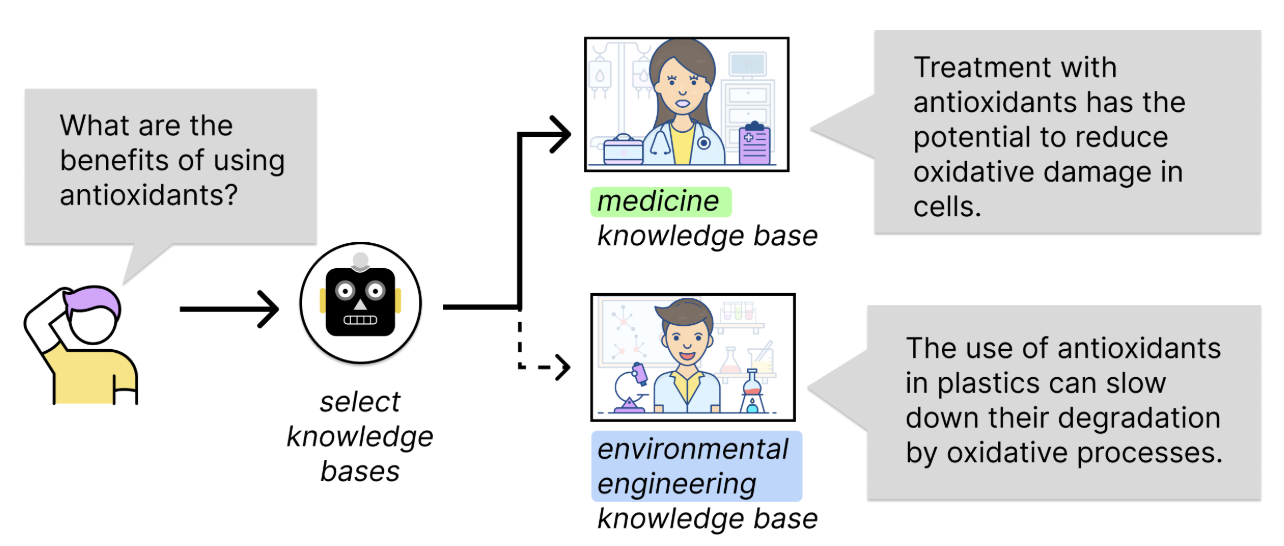

Thus, information that seems correct and relevant at first glance can be irrelevant or even wrong when we know the full context behind the user’s question.

## 2.2 Enhancing Data Quality by Replacing Abbreviations and Technical Terms

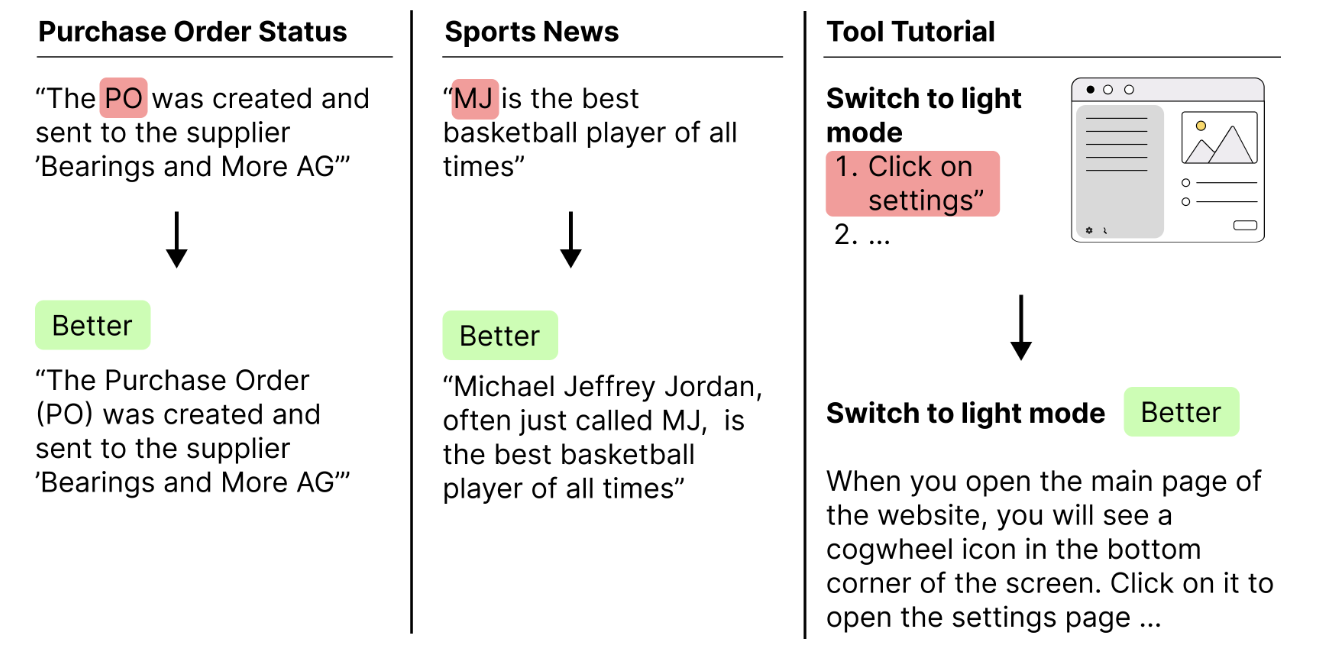

In [ ]:
!wget https://github.com/polzerdo55862/RAG-with-Python-Cookbook/raw/main/datasets/text_files/blog_post_transformers.txt

**Challenge 1**: Handling documents with many domain-specific abbreviations

In [6]:

def load_file_and_replace_abbreviations():
    """
    Load a text file and replace abbreviations with their full forms
    Returns:
        text (str): The text content of the file with abbreviations replaced
    """
    # tag::load_file_and_replace_abbreviations[]
    import re

    abbreviations_dict = {
        "NLP": "Natural Language Processing",
        "RNN": "Recurrent Neural Network",
        "LSTM": "Long Short-Term Memory",
        "GRU": "Gated Recurrent Unit",
        "TF": "Transformer",
        "MHA": "Multi-Head Attention",
        "FFN": "Feed-Forward Network",
    }

    # Load the sample text file
    file_path = "blog_post_transformers.txt"
    with open(file_path, "r") as file:
        text = file.read()

    # Replace abbreviations in the text
    for abbr, full_form in abbreviations_dict.items():
        text = re.sub(rf"\b{abbr}\b", f"{full_form} ({abbr})", text)
    # end::load_file_and_replace_abbreviations[]

    return text

# replace abbreviations with full words
processed_text = load_file_and_replace_abbreviations()

In [7]:
processed_text

'Unveiling Transformer Models: A Revolution in ML\n\nIn the realm of ML and DL, few advancements have reshaped the field as profoundly as Transformer models. First introduced in the seminal paper "Attention Is All You Need," Transformer models have become the backbone of modern Natural Language Processing (NLP) and are extending their reach into CV and beyond.\n\nThe Challenges Before Transformers\n\nPrior to Transformers, models like RNNs, LSTMs, and GRUs were the primary tools for sequential data. While effective, these architectures faced significant challenges:\n\nSequential Computation: Processing one step at a time limited their ability to leverage parallelism, making training slower.\n\nLong-Range Dependencies: Understanding relationships between distant elements in a sequence was difficult.\n\nVanishing Gradients: Gradients diminished over long sequences, hampering effective learning.\n\nEnter Transformers, which bypass these limitations with a novel approach: SA.\n\nThe Anatom

**Challenge 2**: Handling documents with many images

In [ ]:
!wget https://github.com/polzerdo55862/RAG-with-Python-Cookbook/raw/main/datasets/text_files/EMEA_drives_revenue.txt

In [10]:
from langchain_core.prompts import PromptTemplate

In [11]:
def make_text_chunks_self_explanatory():
    # tag::make_text_chunks_self_explanatory[]
    import os

    file_path = "EMEA_drives_revenue.txt"

    with open(file_path, "r") as file:
        text = file.read()

    prompt_template = PromptTemplate.from_template(
        f"""
        The text below contains a financial report including a lot of abbreviations and
        technical terms from the finance domain. Please replace the abbreviations with
        their full forms and provide a brief explanation of the technical terms, so the
        whole text get's easier to read and understandable for everyone.

        Make sure it's easy enough, that a 10 years old school kid could understand it.

        Often used abbreviations are:
        - EMEA: Europe, Middle East, and Africa
        - BD: Business Development
        - YoY: Year-over-Year
        - APAC: Asia-Pacific

        Text:
        {text}
        """
    )

    prompt = prompt_template.invoke({"text": text})
    enhanced_text = llm.invoke(prompt)

    # end::make_text_chunks_self_explanatory[]
    return enhanced_text

enhanced_text = make_text_chunks_self_explanatory()

In [13]:
enhanced_text.content

"The company had a great second quarter of 2019 (Q2 19)!  The Business Development (BD) team, which is the team that finds new customers and grows sales, did a fantastic job.\n\nSales went way up, especially in Europe, the Middle East, and Africa (EMEA).  This area was the biggest reason for the company's success.  Sales in EMEA were 2.3 times higher than they were in the same period the year before (Year-over-Year or YoY growth).\n\n**Here's what happened:**\n\n* **EMEA was amazing!**  Sales were really strong in 20 different countries in EMEA.\n\n* **Top Sellers:** The United States (28% of total sales), Spain (20%), India (15%), and Norway (11%) were the best-performing countries in the second quarter of 2019.  Imagine the total sales as a giant pizza; the US got the biggest slice!\n\n* **Year-over-Year (YoY) Growth:** The BD team's sales were much higher than they were in the second quarter of 2018. This shows they're doing a great job selling the company's products or services.\n\

In [14]:
# write enhanced_text to a new .txt file
output_file_path = "EMEA_drives_revenue_enhanced.txt"
with open(output_file_path, "w") as file:
    file.write(enhanced_text.content)

### 2.3 Improving Search Accuracy by Embedding Hypothetical Questions

In [ ]:
import PyPDF2

def load_text_from_sample_chat_history():
    """
    Load text from a sample chat history stored as PDF
    Returns:
        text (str): The text from the sample chat history
    """

    file_path = "../datasets/pdf_files/AI_in_Factories_Discussion_Cleaned.pdf"

    def load_pdf(file_path):
        """
        Load and read a PDF file
        Returns the text content as a string
        """
        with open(file_path, "rb") as file:
            # Create PDF reader object
            reader = PyPDF2.PdfReader(file)

            # Extract text from all pages
            text = ""
            for page in reader.pages:
                text += page.extract_text()

            return text

    # Example usage
    text = load_pdf(file_path=file_path)

    return text


# load pdf with a sample chat history
text = load_text_from_sample_chat_history()


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[
        "\n\n",
    ],
)

# Split the text into smaller chunks
text_chunks = text_splitter.split_text(text)

In [ ]:

def generate_hypothetical_questions(text):
    """
    Generate hypothetical questions from the text
    Args:
        text (str): The text to generate hypothetical questions from
    Returns:
        hypothetical_questions (list): List of hypothetical questions
    """
    # tag::generate_hypothetical_questions[]
    import os
    from openai import OpenAI
    from pydantic import BaseModel
    import textwrap

    file_path = "../datasets/text_files/AI_in_factories_chat.txt"

    with open(file_path, "r") as file:
        text = file.read()

    client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

    prompt = textwrap.dedent(
        f"""
        Below you can find a chat history between two students.

        Please generate 5 hypothetical questions that could be
        answered using the information from the discussion.
        The questions should focus on key details, definitions, and
        information present in the text.

        Chat History:
        {text}
        """
    )

    class HypotheticalQuestions(BaseModel):
        questions: list[str]

    # generate hypothetical questions using the GPT-4 model
    completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-4o",
        response_format=HypotheticalQuestions,
    )

    hypothetical_questions = completion.choices[0].message.parsed.questions
    # end::generate_hypothetical_questions[]

    return hypothetical_questions

hypothetical_questions = generate_hypothetical_questions(text)


TypeError: You tried to pass a `BaseModel` class to `chat.completions.create()`; You must use `beta.chat.completions.parse()` instead

In [ ]:
hypothetical_questions

['How can AI, specifically through robotic process automation (RPA), contribute to reducing operational costs in manufacturing?',
 'What measures could be taken to minimize workplace injuries in manufacturing using AI technologies?',
 'How does machine vision in AI contribute to improving quality control in manufacturing processes?',
 'What potential challenges have companies faced due to system reliability issues with AI implementations in manufacturing?',
 'How might AI adoption potentially exacerbate inequality between large corporations and smaller companies?']

### 2.4 Splitting Documents Using Character Splitting

In [ ]:

def character_text_splitting():
    """
    Split the text into smaller chunks using the CharacterTextSplitter
    """
    # tag::character_text_splitting[]
    from langchain.text_splitter import CharacterTextSplitter

    file_path = "../datasets/text_files/blog_post_transformers.txt"

    # Load example document
    with open(file_path, "r") as file:
        text = file.read()

    text_splitter = CharacterTextSplitter(
        chunk_size=100,
        chunk_overlap=0,
        separator="",
        length_function=len,
    )

    text_chunks = text_splitter.create_documents([text])
    # end::character_text_splitting[]

    return text_chunks

text_chunks = character_text_splitting()

In [ ]:
text_chunks

[Document(metadata={}, page_content='Unveiling Transformer Models: A Revolution in ML\n\nIn the realm of ML and DL, few advancements have r'),
 Document(metadata={}, page_content='eshaped the field as profoundly as Transformer models. First introduced in the seminal paper "Attent'),
 Document(metadata={}, page_content='ion Is All You Need," Transformer models have become the backbone of modern NLP and are extending th'),
 Document(metadata={}, page_content='eir reach into CV and beyond.\n\nThe Challenges Before Transformers\n\nPrior to Transformers, models lik'),
 Document(metadata={}, page_content='e RNNs, LSTMs, and GRUs were the primary tools for sequential data. While effective, these architect'),
 Document(metadata={}, page_content='ures faced significant challenges:\n\nSequential Computation: Processing one step at a time limited th'),
 Document(metadata={}, page_content='eir ability to leverage parallelism, making training slower.\n\nLong-Range Dependencies: Understanding'),
 Do

### 2.5 Splitting Documents Using Recursive Text Splitters

In [ ]:

def recursive_text_splitting():
    """
    Split the text into smaller chunks using the RecursiveCharacterTextSplitter
    """
    # tag::recursive_chunking[]
    from langchain_text_splitters import RecursiveCharacterTextSplitter
    import PyPDF2

    file_path = "../datasets/pdf_files/daily_insights.pdf"

    with open(file_path, "rb") as file:
        reader = PyPDF2.PdfReader(file)

        text = ""
        for page in reader.pages:
            text += page.extract_text()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,
        chunk_overlap=0,
        length_function=len,
        is_separator_regex=False,
    )

    chunks = text_splitter.split_text(text)
    # end::recursive_chunking[]

    return chunks


# load sample pdf and chunk it using recursive character text splitter
text_chunks = recursive_text_splitting()


In [ ]:
print(text_chunks)
print(f"Number of chunks: {len(text_chunks)}")

for chunk in text_chunks:
    print(f"Chunk length: {len(chunk)}")

['The\nDaily\nInsight\nPolitics:\nNew\nClimate\nAccord\nSets\nAmbitious\nGoals\nWorld\nleaders\nconvened\nthis\nweek\nin\nGeneva\nto\nsign\na\ngroundbreaking\nclimate\naccord\naimed\nat\nreducing\nglobal\ngreenhouse\ngas\nemissions', 'by\n50%\nby\n2035.\nThis\nlandmark\nagreement,\nsupported\nby\nover\n190\ncountries,\nincludes\nprovisions\nfor\nrenewable\nenergy\ninvestments,\nreforestation\nprojects,\nand\ntechnological\ninnovations.\nCritics,', 'however,\nargue\nthat\nthe\naccord\nlacks\nbinding\nenforcement\nmechanisms,\nwhich\ncould\nundermine\nits\nimpact.\nSports:\nThrilling\nChampionship\nFinal\nThe\nglobal\nspotlight\nwas\non\nthe\nNational\nFootball', 'Championship\nlast\nnight\nas\nthe\nBlue\nFalcons\ntriumphed\nover\nthe\nSilver\nWolves\nin\na\nnail-biting\nmatch.\nThe\nfinal\nscore,\n28-27,\nwas\ndecided\nby\na\nlast-minute\nfield\ngoal.\nQuarterback\nAlex\nHart\nof\nthe\nBlue', 'Falcons\nwas\nnamed\nMVP\nfor\nhis\nexceptional\nperformance,\nthrowing\nthree\ntouchdown\npas

### 2.6 Document Aware Splitting

In [ ]:

def document_aware_chunking():
    """
    Depending on the file extension, the text is split into chunks using the appropriate text splitter.
    Args:
        file_extension (str): The file extension of the document
    Returns:
        chunks (list): List of text chunks
    """
    # tag::document_aware_text_splitter[]
    import os

    file_path = "../datasets/markdown_files/random_md_code.md"
    file_extension = os.path.splitext(file_path)[1]

    with open(file_path, "r") as file:
        file_text = file.read()

    from langchain_text_splitters import (
        PythonCodeTextSplitter,
        LatexTextSplitter,
        MarkdownHeaderTextSplitter,
    )

    if file_extension == ".py":
        splitter = PythonCodeTextSplitter(chunk_size=500, chunk_overlap=50)
    elif file_extension == ".tex":
        splitter = LatexTextSplitter(chunk_size=500, chunk_overlap=50)
    elif file_extension == ".md":
        headers_to_split_on = [
            ("#", "Header 1"),
            ("##", "Header 2"),
            ("###", "Header 3"),
        ]

        splitter = MarkdownHeaderTextSplitter(headers_to_split_on)

    chunks = splitter.split_text(file_text)
    # end::document_aware_text_splitter[]

    return chunks

text_chunks = document_aware_chunking()

In [ ]:
text_chunks

[Document(metadata={'Header 1': 'Random Markdown Page'}, page_content='---'),
 Document(metadata={'Header 1': 'Random Markdown Page', 'Header 2': 'Table of Contents'}, page_content='1. [Introduction](#introduction)\n2. [Code Snippets](#code-snippets)\n3. [Lists](#lists)\n4. [Quotes and Tips](#quotes-and-tips)\n5. [Tables](#tables)\n6. [Images and Links](#images-and-links)  \n---'),
 Document(metadata={'Header 1': 'Random Markdown Page', 'Header 2': 'Introduction'}, page_content='Welcome to a randomly generated Markdown page. This is an example to showcase various Markdown elements.'),
 Document(metadata={'Header 1': 'Random Markdown Page', 'Header 2': 'Introduction', 'Header 3': 'Highlights'}, page_content='- **Simple formatting**: *italics*, **bold**, `inline code`\n- `Monospace text`\n- ~~Strikethrough~~  \n---'),
 Document(metadata={'Header 1': 'Random Markdown Page', 'Header 2': 'Code Snippets'}, page_content='```python\n# Python example\ndef greet(name):\nreturn f"Hello, {name}!"\

### 2.7 Splitting the Text Using Semantic Aware Chunkers

In [ ]:
from docx import Document
from openai import OpenAI

file_path = "../datasets/text_files/random-text-about-5-different-stories.txt"

# read the text from the file
with open(file_path, "r") as file:
    text = file.read()


def langchain_semantic_text_splitting(text):
    # tag::langchain_semantic_text_splitting[]
    from langchain_experimental.text_splitter import SemanticChunker
    from langchain_openai.embeddings import OpenAIEmbeddings

    # Define the Semantic Text Splitter
    text_splitter = SemanticChunker(
        OpenAIEmbeddings(),
        breakpoint_threshold_type="percentile",
        breakpoint_threshold_amount=90,
    )

    # Split textchunks
    chunks = text_splitter.split_text(text)
    return

    # end::langchain_semantic_text_splitting[]

chunks = langchain_semantic_text_splitting(text)

In [ ]:
chunks

['The Intricate World of Bioluminescent Fungi in Tropical Forests.Deep within the lush, verdant landscapes of tropical rainforests, a fascinating phenomenon quietly unfolds beneath the dense canopy.\n\nBioluminescent fungi, often overlooked by casual observers, create a mesmerizing display of natural light that transforms the forest floor into a living canvas of ethereal illumination.\n\nThese remarkable organisms, belonging to several genera including Mycena and Panellus, have evolved a unique ability to produce light through a complex biochemical process known as bioluminescence.\n\nThe mechanism behind this natural light show is both intricate and beautiful.\n\nWhen specific enzymes called luciferases interact with a light-emitting molecule called luciferin, a chemical reaction occurs that releases energy in the form of visible light.',
 'Unlike many bioluminescent creatures that use this ability for communication or predation, these fungi seem to employ their luminescence for more 

In [ ]:

# initialize the api key
client = OpenAI()
embedding_model = "text-embedding-3-small"


def from_text_to_embeddings(chunks, client, embedding_model):
    """
    Translate sentences into vector embeddings

    Attributes:
        - text_chunks (list): list of example strings

    Returns:
        - embeddings_df (DataFrame): data frame with the columns "text_chunk" and "embeddings"
    """
    import os

    # Initialize the OpenAI client with your API key
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    # create new data frame using text chunks list
    embeddings_df = pd.DataFrame(text_chunks).rename(columns={0: "text_chunk"})

    # helper function to get the embeddings for a text chunk
    def _get_embeddings(text_chunk, client, embedding_model):
        embedding = (
            client.embeddings.create(input=[text_chunk], model=embedding_model)
            .data[0]
            .embedding
        )

        return embedding

    # iterate over embeddings_df["text_chunks"] and create a new data frame with the embeddings
    embeddings_df["embeddings"] = embeddings_df["text_chunk"].apply(
        _get_embeddings, client=client, embedding_model="text-embedding-3-small"
    )

    # split the embeddings column into individual columns for each vector dimension
    embeddings_df = embeddings_df["embeddings"].apply(pd.Series)
    embeddings_df["text_chunk"] = text_chunks

    return embeddings_df

embeddings_df = from_text_to_embeddings(
    chunks, client, embedding_model
)

In [ ]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,text_chunk
0,0.020937,-0.029581,0.060302,0.030175,-0.044704,0.015468,-0.032553,0.018821,0.035335,-0.024111,...,0.006206,-0.011990,0.005784,-0.011550,0.029034,-0.000083,-0.020616,-0.048080,-0.008881,The\nDaily\nInsight\nPolitics:\nNew\nClimate\n...
1,0.023771,0.021001,0.082569,0.054311,-0.024412,0.049875,0.022796,0.022591,0.029797,0.017719,...,-0.019719,0.004407,-0.015142,-0.009776,-0.001186,-0.013591,-0.004802,-0.008622,-0.005789,"by\n50%\nby\n2035.\nThis\nlandmark\nagreement,..."
2,0.039027,0.016830,0.033579,0.024436,-0.019783,0.014376,-0.014200,-0.005735,0.017302,-0.011604,...,0.000598,-0.000887,0.014281,-0.025825,-0.006689,-0.026364,0.015899,0.007066,0.015481,"however,\nargue\nthat\nthe\naccord\nlacks\nbin..."
3,0.041047,-0.022108,0.009025,-0.013561,-0.022563,0.003080,0.012524,0.000922,-0.048591,-0.012421,...,0.009453,0.039224,-0.012535,-0.005729,0.001501,-0.039338,-0.001113,0.019806,0.036443,Championship\nlast\nnight\nas\nthe\nBlue\nFalc...
4,0.046435,-0.047211,-0.012487,0.009545,-0.009858,-0.011711,-0.005439,0.025453,0.050677,0.022921,...,-0.002532,0.034940,-0.004516,-0.027460,-0.005536,-0.000607,0.031588,0.019363,0.047804,Falcons\nwas\nnamed\nMVP\nfor\nhis\nexceptiona...
5,0.034707,-0.038892,-0.003101,0.089962,-0.075728,-0.009454,-0.011690,0.044129,0.037964,-0.017842,...,0.007919,-0.043252,0.040145,-0.017792,0.029119,0.015361,-0.019546,-0.012811,0.027966,Healthcare:\nBreakthrough\nin\nCancer\nResearc...
6,-0.012899,-0.013032,-0.002193,0.042692,-0.053480,-0.003394,0.005846,0.073269,0.029081,0.036466,...,0.017026,0.003925,-0.002279,-0.001904,0.002723,0.003563,-0.007125,-0.049112,-0.018607,immunotherapy\ntechnique\nthat\nhas\nshown\na\...
7,0.017635,-0.035833,0.069585,0.073917,-0.027381,-0.015934,0.022234,0.057828,-0.015709,-0.034455,...,-0.018803,-0.013494,0.002552,0.002271,0.048659,-0.005010,-0.001848,-0.012080,-0.005587,"next\nyear,\nraising\nhopes\nfor\nmillions\nof..."


### 2.8 Splitting Text Using Agentic Chunkers

In [ ]:

def agentic_chunking_create_propositions(text):
    """
    Generate propositions from the text
    Args:
        text (str): The text to generate propositions from
    Returns:
        propositions (list): List of propositions
    """

    # tag::agentic_chunking_create_propositions[]
    from langchain import hub
    from langchain_openai import ChatOpenAI  # Import ChatOpenAI
    from pydantic import BaseModel
    from typing import List

    # pull the prompt template from the langchain hub
    obj = hub.pull("wfh/proposal-indexing")

    # define the llm you want to use
    llm = ChatOpenAI(model="gpt-4o")

    # A Pydantic model to extract sentences from the passage
    class Sentences(BaseModel):
        sentences: List[str]

    extraction_llm = llm.with_structured_output(Sentences)

    # Create the sentence extraction chain
    extraction_chain = obj | extraction_llm

    # Test it out
    propositions = extraction_chain.invoke(
        """
        On July 20, 1969, astronaut Neil Armstrong walked on the moon .
        He was leading the NASA's Apollo 11 mission.
        Armstrong famously said, "That's one small step for man, one
        giant leap for mankind" as he stepped onto the lunar surface.
        """
    )

    print(propositions)
    # end::agentic_chunking_create_propositions[]
    return propositions

In [ ]:
# propositions
propositions = agentic_chunking_create_propositions(text)

c:\Users\z004j58u\repos\others\rag-oreily-book\.venv_ch02_chunking_data\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


sentences=['On July 20, 1969, astronaut Neil Armstrong walked on the moon.', "Neil Armstrong was leading NASA's Apollo 11 mission.", 'Neil Armstrong famously said "That\'s one small step for man, one giant leap for mankind".', 'Neil Armstrong said this quote as he stepped onto the lunar surface.']


In [ ]:
for sentence in propositions.sentences:
    print(sentence)

On July 20, 1969, Neil Armstrong walked on the moon.
Neil Armstrong was an astronaut.
Neil Armstrong was leading NASA's Apollo 11 mission.
Neil Armstrong famously said, "That's one small step for man, one giant leap for mankind" as he stepped onto the lunar surface.
